# Test Image Preprocessing

This notebook tests the preprocessing utilities for chest X-ray images.
Tests normalization, resizing, windowing, and image-mask pair preprocessing.

## Step 1: Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 2: Set Up Project Imports

In [2]:
import sys
from pathlib import Path

# Add your project to Python path
project_path = Path('/content/drive/MyDrive/TB_Segementation/tb-segmentation')
sys.path.insert(0, str(project_path))

# Verify path exists
print(f"Project path: {project_path}")
print(f"Path exists: {project_path.exists()}")
print(f"src/data exists: {(project_path / 'src' / 'data').exists()}")

Project path: /content/drive/MyDrive/TB_Segementation/tb-segmentation
Path exists: True
src/data exists: True


## Step 3: Import Functions

In [5]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import logging

# Set matplotlib to inline mode for Colab
%matplotlib inline

# Import preprocessing functions
from src.data.preprocessing import (
    load_image,
    resize_image,
    normalize_image,
    apply_window_level,
    preprocess_image,
    preprocess_mask,
    preprocess_image_mask_pair,
)

# Set up logging
logging.basicConfig(level=logging.INFO)

print("All imports successful!")

All imports successful!


## Step 4: Set Up Data Paths

In [7]:
# Set up paths to data
DATA_ROOT = Path('/content/drive/MyDrive/TB_Segmentation_Data')
TBX11K_PATH = DATA_ROOT / 'tbx11k'

images_dir = TBX11K_PATH / 'tbx11k-simplified' / 'images'
masks_dir = TBX11K_PATH / 'tbx11k-simplified' / 'weak_masks'

print(f"Images dir: {images_dir}")
print(f"Masks dir: {masks_dir}")

# Verify paths exist
print(f"\nImages dir exists: {images_dir.exists()}")
print(f"Masks dir exists: {masks_dir.exists()}")

Images dir: /content/drive/MyDrive/TB_Segmentation_Data/tbx11k/tbx11k-simplified/images
Masks dir: /content/drive/MyDrive/TB_Segmentation_Data/tbx11k/tbx11k-simplified/weak_masks

Images dir exists: True
Masks dir exists: True


## Step 5: Load Sample Image

Sample image: s4760.png
Original size: (512, 512)
Original mode: RGB


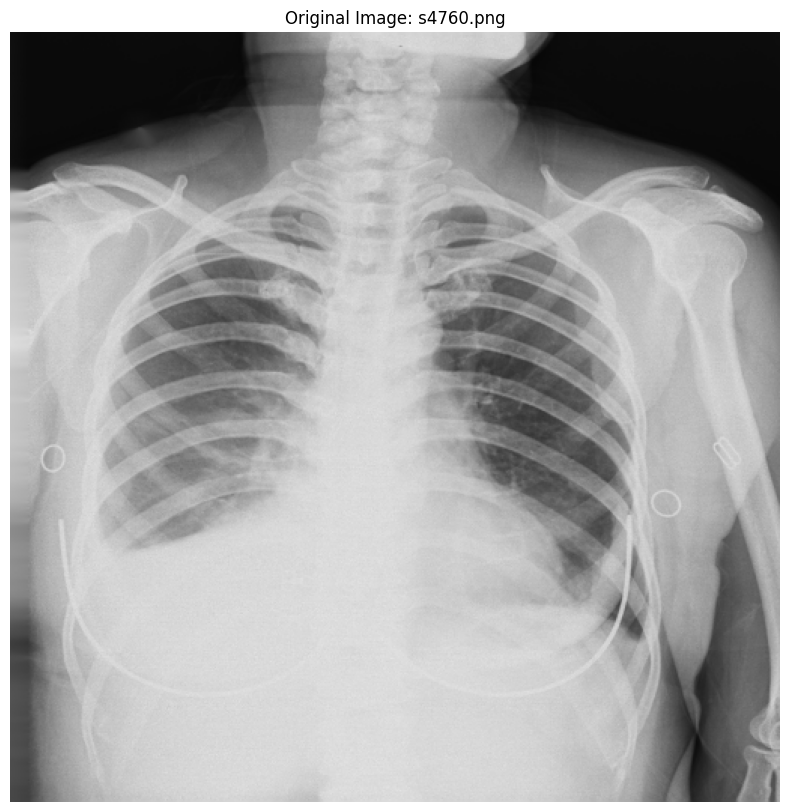

In [8]:
# Get a sample image
image_files = list(images_dir.glob('*.png'))
if len(image_files) > 0:
    sample_image_path = image_files[0]
    print(f"Sample image: {sample_image_path.name}")

    # Load original image
    original_image = load_image(sample_image_path)
    print(f"Original size: {original_image.size}")
    print(f"Original mode: {original_image.mode}")

    # Display original image
    plt.figure(figsize=(10, 10))
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original Image: {sample_image_path.name}")
    plt.axis('off')
    plt.show()
else:
    print("No images found!")

## Step 6: Test Resizing

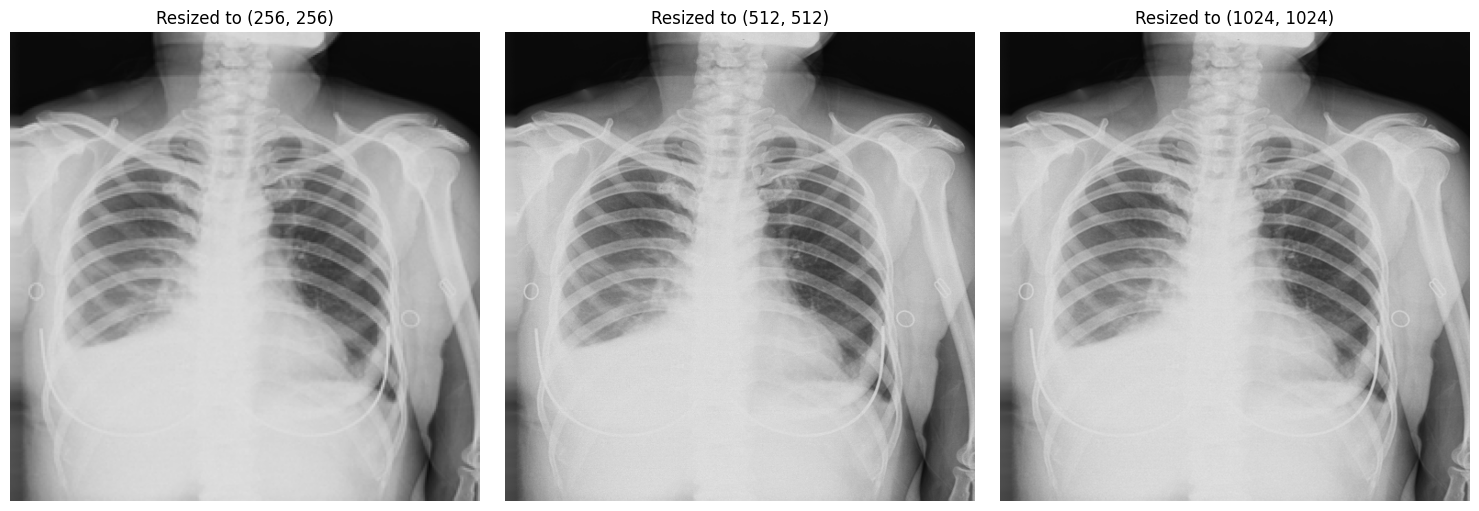

Resizing test complete!


In [10]:
# Test resizing to different sizes
target_sizes = [(256, 256), (512, 512), (1024, 1024)]

fig, axes = plt.subplots(1, len(target_sizes), figsize=(15, 5))

for idx, target_size in enumerate(target_sizes):
    resized = resize_image(original_image, target_size=target_size)
    axes[idx].imshow(resized, cmap='gray')
    axes[idx].set_title(f"Resized to {target_size}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Resizing test complete!")

## Step 7: Test Normalization Methods

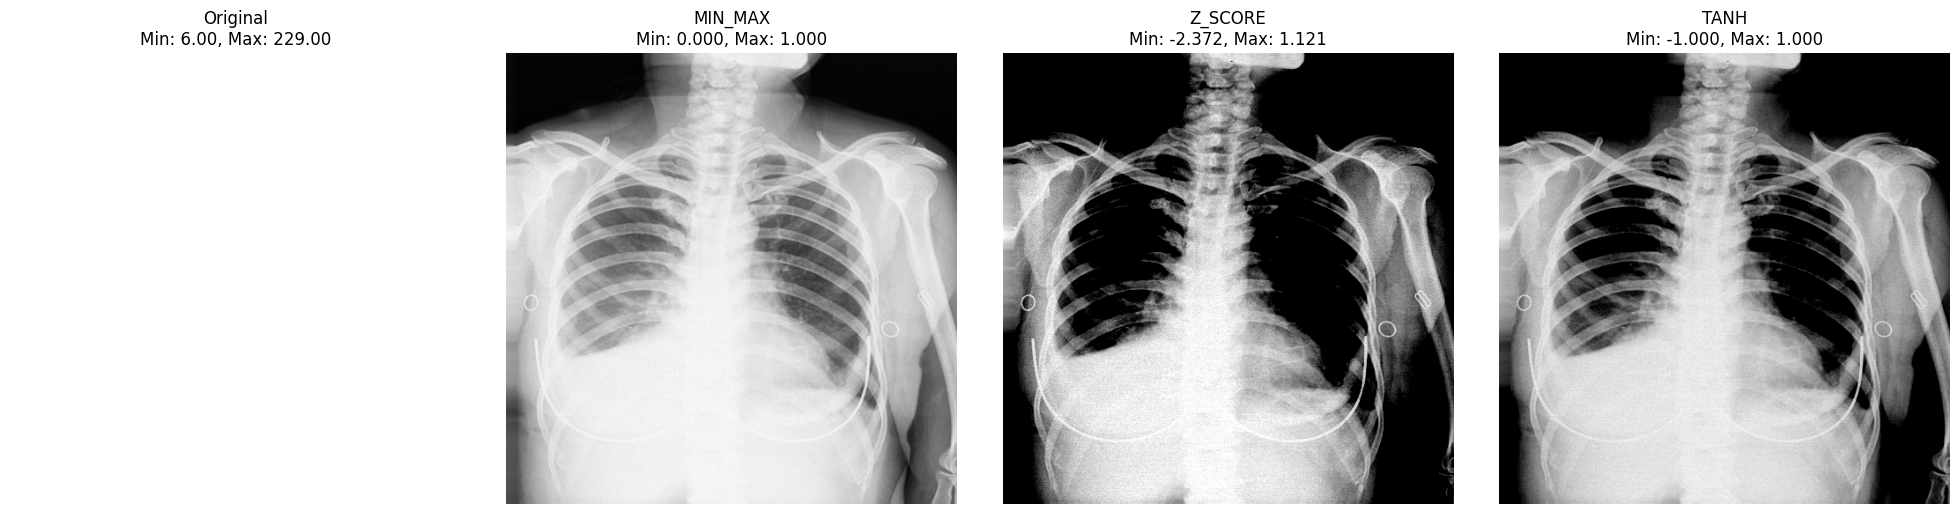

Normalization test complete!


In [11]:
# Convert image to numpy array first
img_array = np.array(original_image, dtype=np.float32)

# Test different normalization methods
methods = ['min_max', 'z_score', 'tanh']

fig, axes = plt.subplots(1, len(methods) + 1, figsize=(20, 5))

# Original (for comparison)
axes[0].imshow(img_array, cmap='gray')
axes[0].set_title(f"Original\nMin: {img_array.min():.2f}, Max: {img_array.max():.2f}")
axes[0].axis('off')

# Normalized versions
for idx, method in enumerate(methods, 1):
    normalized = normalize_image(img_array, method=method)
    axes[idx].imshow(normalized, cmap='gray')
    axes[idx].set_title(f"{method.upper()}\nMin: {normalized.min():.3f}, Max: {normalized.max():.3f}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Normalization test complete!")

## Step 8: Test Complete Preprocessing Pipeline

Preprocessed image shape: (512, 512)
Preprocessed image dtype: float32
Preprocessed image range: [0.000, 1.000]


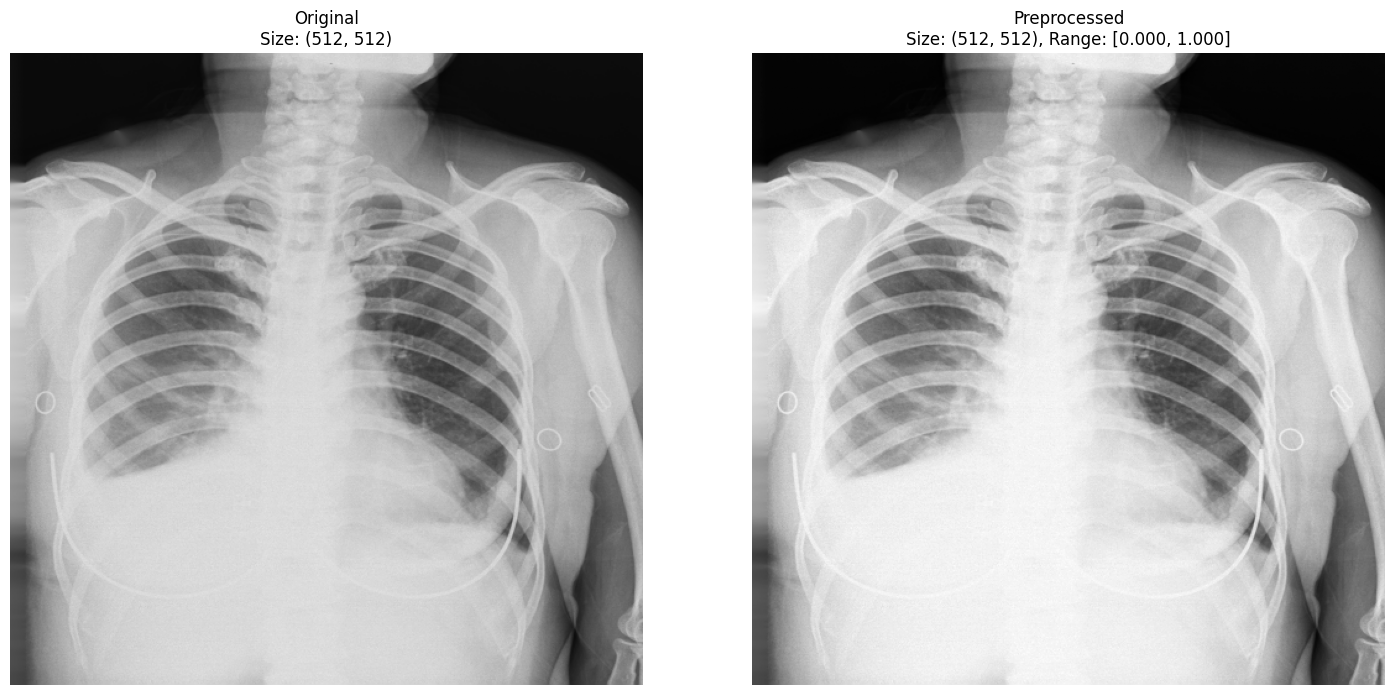

Complete preprocessing test successful!


In [12]:
# Test complete preprocessing pipeline
target_size = (512, 512)

preprocessed = preprocess_image(
    image=original_image,
    target_size=target_size,
    normalize=True,
    normalization_method='min_max',
    apply_window=False,
    convert_to_grayscale=True
)

print(f"Preprocessed image shape: {preprocessed.shape}")
print(f"Preprocessed image dtype: {preprocessed.dtype}")
print(f"Preprocessed image range: [{preprocessed.min():.3f}, {preprocessed.max():.3f}]")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title(f"Original\nSize: {original_image.size}")
axes[0].axis('off')

axes[1].imshow(preprocessed, cmap='gray')
axes[1].set_title(f"Preprocessed\nSize: {preprocessed.shape[::-1]}, Range: [{preprocessed.min():.3f}, {preprocessed.max():.3f}]")
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Complete preprocessing test successful!")

## Step 9: Test Window/Level Adjustment (CXR-specific)

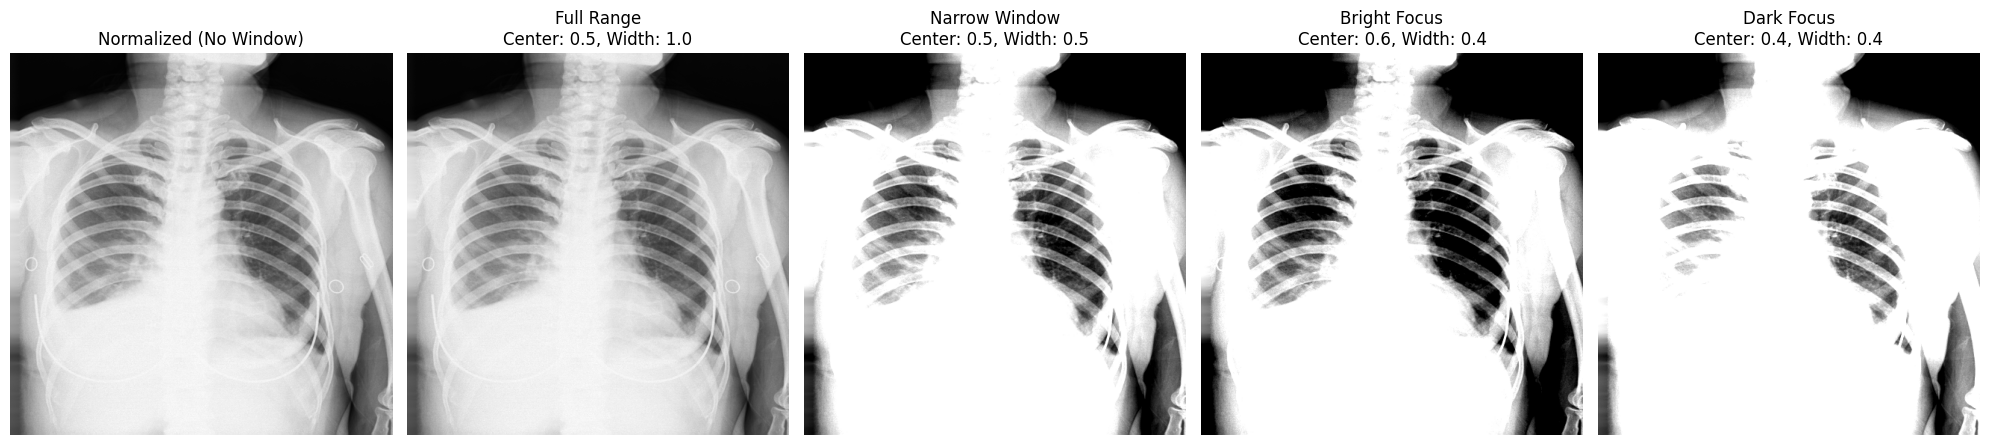

Window/level adjustment test complete!


In [13]:
# Test window/level adjustment
# First normalize the image
normalized_img = normalize_image(img_array, method='min_max')

# Test different window settings
window_configs = [
    {'center': 0.5, 'width': 1.0, 'name': 'Full Range'},
    {'center': 0.5, 'width': 0.5, 'name': 'Narrow Window'},
    {'center': 0.6, 'width': 0.4, 'name': 'Bright Focus'},
    {'center': 0.4, 'width': 0.4, 'name': 'Dark Focus'},
]

fig, axes = plt.subplots(1, len(window_configs) + 1, figsize=(20, 5))

# Original normalized
axes[0].imshow(normalized_img, cmap='gray')
axes[0].set_title("Normalized (No Window)")
axes[0].axis('off')

# Windowed versions
for idx, config in enumerate(window_configs, 1):
    windowed = apply_window_level(normalized_img, config['center'], config['width'])
    axes[idx].imshow(windowed, cmap='gray')
    axes[idx].set_title(f"{config['name']}\nCenter: {config['center']}, Width: {config['width']}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Window/level adjustment test complete!")

## Step 10: Test Image-Mask Pair Preprocessing

Found mask: s4760.npy
Preprocessed image shape: (512, 512)
Preprocessed mask shape: (512, 512)
Mask unique values: [0]
Mask has TB pixels: 0 / 262144


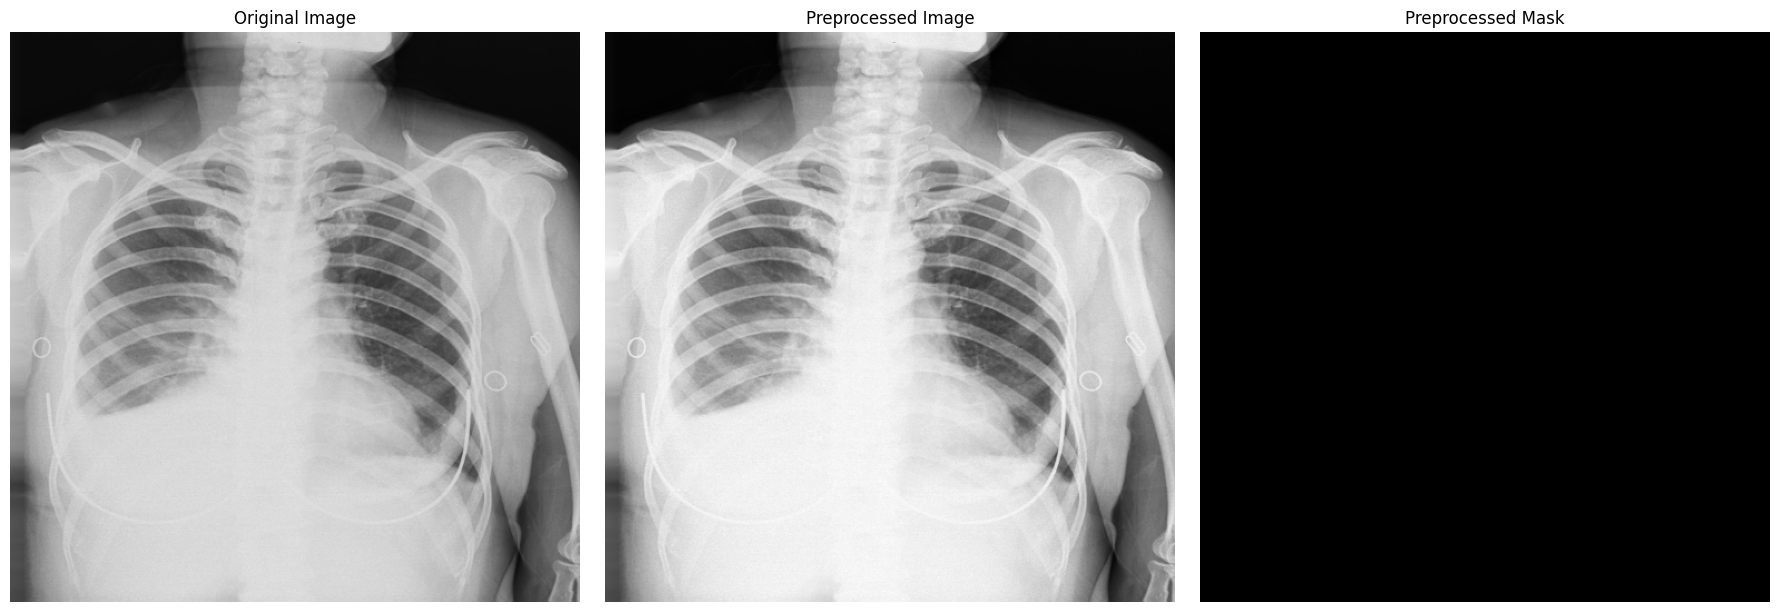

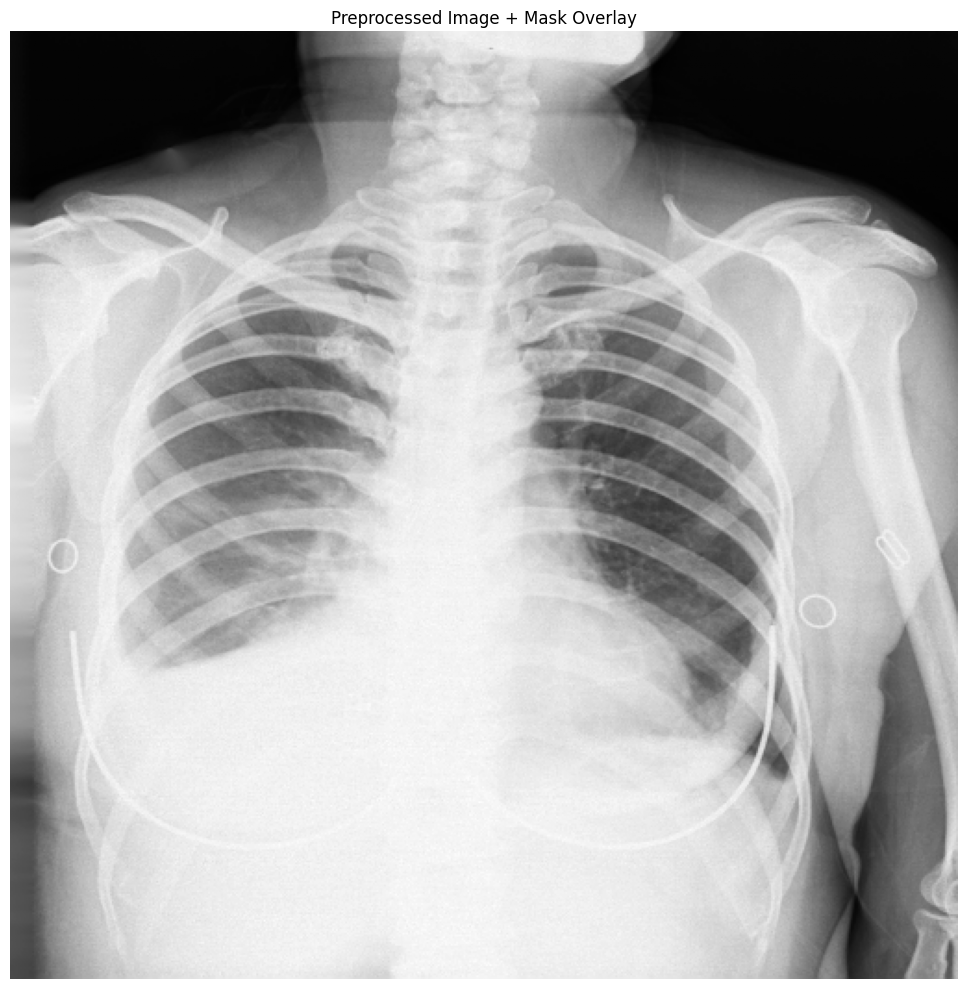

Image-mask pair preprocessing test successful!


In [14]:
# Find corresponding mask for the sample image
mask_name = sample_image_path.stem
mask_path = masks_dir / f"{mask_name}.npy"

if mask_path.exists():
    print(f"Found mask: {mask_path.name}")

    # Preprocess image and mask together
    preprocessed_img, preprocessed_mask = preprocess_image_mask_pair(
        image=sample_image_path,
        mask=mask_path,
        target_size=(512, 512),
        normalize=True,
        normalization_method='min_max',
        apply_window=False,
        convert_to_grayscale=True
    )

    print(f"Preprocessed image shape: {preprocessed_img.shape}")
    print(f"Preprocessed mask shape: {preprocessed_mask.shape}")
    print(f"Mask unique values: {np.unique(preprocessed_mask)}")
    print(f"Mask has TB pixels: {preprocessed_mask.sum()} / {preprocessed_mask.size}")

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Preprocessed image
    axes[1].imshow(preprocessed_img, cmap='gray')
    axes[1].set_title("Preprocessed Image")
    axes[1].axis('off')

    # Preprocessed mask
    axes[2].imshow(preprocessed_mask, cmap='gray')
    axes[2].set_title("Preprocessed Mask")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Overlay visualization
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(preprocessed_img, cmap='gray')

    # Overlay mask (red overlay)
    mask_colored = np.zeros((*preprocessed_mask.shape, 4), dtype=np.float32)
    mask_colored[:, :, 0] = 1.0  # Red channel
    mask_colored[:, :, 3] = preprocessed_mask.astype(np.float32) * 0.5  # Alpha channel
    ax.imshow(mask_colored)

    ax.set_title("Preprocessed Image + Mask Overlay")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    print("Image-mask pair preprocessing test successful!")
else:
    print(f"Mask not found: {mask_path}")
    print("Skipping image-mask pair test.")

## Step 11:

All preprocessing functions tested successfully!